# Decision Trees

This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur with updates by Ross Beveridge

Latest Update 11/18/2021

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

In [9]:
%matplotlib inline
%autosave 0
import numpy as np
import matplotlib.pyplot as plt

Autosave disabled


## To Start, Recall Iris Data

The Iris data is an excellent dataset to introduce decision trees.  Recall what you already konw about this dataset.

In [17]:
from sklearn import datasets
iris = datasets.load_iris()
Xa = iris.data
y  = iris.target

Recall that early in the semester we used a tool provided by the seaborn API that generates pair plots showing pairwise comparisons of features.  This is an excellent way to visualize the Iris data.

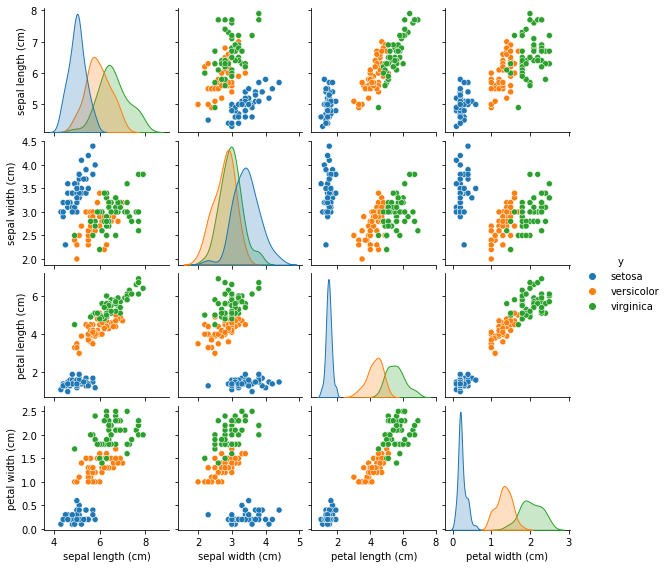

In [18]:
import seaborn as sns
import pandas as pd
iris_df = pd.DataFrame(Xa, columns=iris.feature_names)
iris_df['y'] = np.array([iris.target_names[i] for i in iris.target])
iris_pal = sns.color_palette("tab10",3)
sns.pairplot(iris_df, hue='y', height=2.0, palette=iris_pal);

Take a moment to reaquaint yourself with the Iris data.  Consider, for example, is there a single feature that might be used to predict the type of iris?

## Decision Trees - Divide and Conquer

Decision trees capture the very intuitive way in which we as humans might make decisions, as a set of rules.  As an example consider the following very simple decision tree that provides high classification accuracy between Iris versicolor and Iris virginica:

<img style="padding: 10px; float:center;" alt="created by X7q in public domain" src="https://upload.wikimedia.org/wikipedia/commons/c/cf/Decision_stump.svg" width="400">

To see this in code, let's consider the iris dataset and use the **last two** features, petal length and petal width:

In [49]:
features = [2,3]
X = iris.data[:, features]
y = iris.target
fnames = np.array([iris['feature_names'][i] for i in features])
print(f'Using features: {fnames}')

Using features: ['petal length (cm)' 'petal width (cm)']


Now, let's create a decision tree using scikit-learn's [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) implementation of decision trees:

In [50]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
tree = DecisionTreeClassifier(max_depth=2,random_state=42)
tree.fit(X, y);

As it name suggests, the `max_depth` parameter controls the depth of the resulting tree. 
Next, let's plot the tree:

Training Set Accuracy is: 0.96


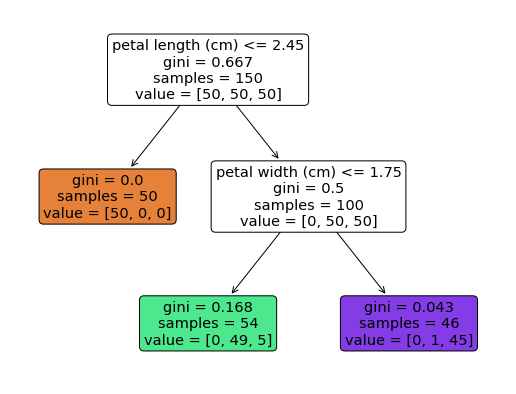

In [51]:
plt.figure(figsize=(9,7))
plot_tree(tree, filled=True, rounded=True, feature_names=fnames)
print(f'Training Set Accuracy is: {tree.score(X,y):2.2f}')

Note the excellent support provided for [plotting the decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) which we just utilized.

Perhaps an even more helpful visualization follows, where the actual dividing up of the space into labels - red, yellow, blue - is highlighted and related both to the samples and the decision tree.

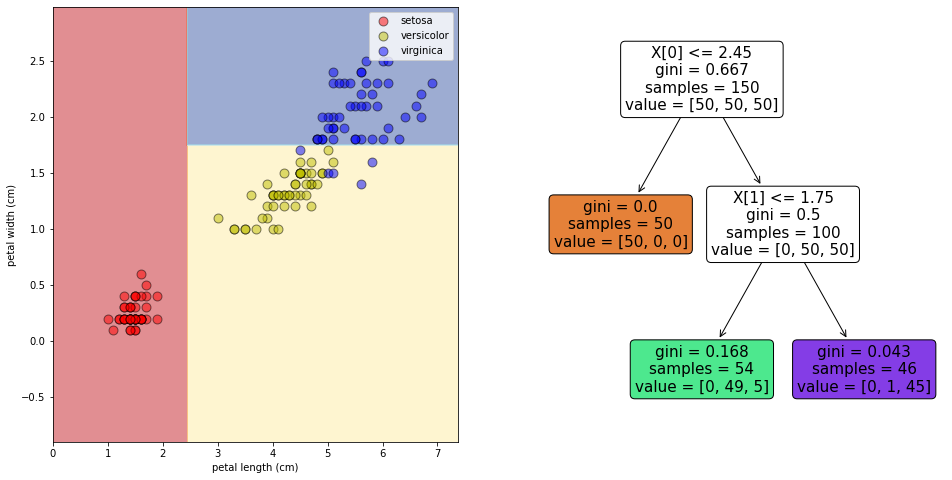

In [52]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

n_classes = 3
plot_colors = "ryb"

# plot the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = ax1.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.5)

ax1.set_xlabel(iris.feature_names[features[0]])
ax1.set_ylabel(iris.feature_names[features[1]])

# plot the training points
for i, color in zip(range(n_classes), plot_colors):
    if True : # Can test for a single class so points do not overlap
        idx = np.where(y == i)
        ax1.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=80, alpha=0.5)
ax1.legend();

plot_tree(tree, ax=ax2, filled=True, rounded=True);

### Explore different features and depths

Below we can explore trees built using different values of the maximum depth parameter.  Note what happens when using all four features versus subsets of features. 

As you are playing, consider what can you say about the form of the decision boundary for decision trees?

Training Set Accuracy is: 0.97


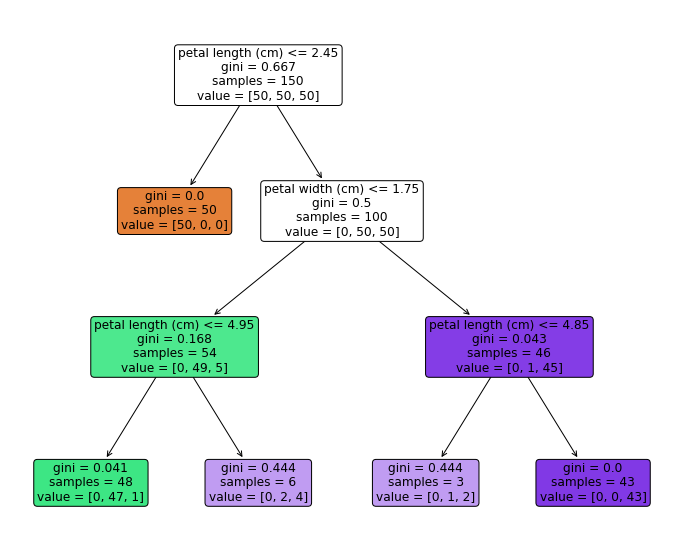

In [53]:
depth_bound = 3
features = [0,1,2,3]
X = iris.data[:, features]
y = iris.target
fnames = np.array([iris['feature_names'][i] for i in features])

tree = DecisionTreeClassifier(max_depth=depth_bound, random_state=42)
tree.fit(X, y)

plt.figure(figsize=(12,10))
plot_tree(tree, filled=True, rounded=True, feature_names=fnames)
print(f'Training Set Accuracy is: {tree.score(X,y):2.2f}')

### The decision tree training algorithm

The decision tree training algorithm iteratively splits the data on the value of a single feature.
At each step the algorithm picks the feature that leads to the greatest "purity" of the resulting split.
Here we will assume binary features.

Input:  $\mathcal{D}$ is a labeled set of examples $(\mathbf{x}_i, y_i)$

*generate_tree*($\mathcal{D}$):

* if stopping criterion:  return
* pick best feature 
* define $\mathcal{D}_0$ as the set of examples for which best features = 0
* define $\mathcal{D}_1$ as the set of examples for which best features = 1
* recursively generate two subtrees using $\mathcal{D}_0$ and $\mathcal{D}_1$

To fully specify the algorithm we need to decide on a stopping criterion, and a way of choosing good features for performing a split on.  Split criteria are based on the idea of looking for splits that decrease the "impurity" in a node in the decision tree, i.e. make it so that the examples are more homogeneous.  Examples of measures that are used to quantify impurity include the Gini impurity and  information gain.

When growing a decision tree you can use one of several stopping criteria:

* if maximum depth has been reached
* if leaf node contain only examples of the same class
* if leaf node contains very few examples

Decision trees can be extended with the option for pruning the tree after it has been created to remove nodes deep in the tree that can lead to overfitting.  They can also be extended to perform regression (cf. the CART decision tree algorithm).

### Advantages and disadvantages of decision trees

#### Advantages

* Simple to understand and interpret, even for a non-expert.
* Whereas most machine learning techniques are "black boxes", decision trees are more of a "white box".
* Easily handle a mix of categorical and numerical data.
* Can handle missing data.
* Fast training.

#### Disadvantages

* Decision trees are unstable, meaning that a small change in the data can lead to a large change in the structure of the model.  This calls into question the interpretation of the model.
* They are often relatively inaccurate, especially for data that is high dimensional. Many other predictors perform better.

Decision trees have been among the most popular classification algorithms because of their speed and versatility.  Their biggest drawback has been their relatively low accuracy.
Random forests are a subsequent development that provide a big improvement in accuracy while maintaining most of their advantages.

### References:

* **ID3**:
Quinlan, J. Ross. "Induction of decision trees." Machine learning 1.1 (1986): 81-106.

* **C4.5**:
Quinlan, J. Ross. C4. 5: programs for machine learning. Morgan Kaufmann Publishers, 1993.

* **CART**: Breiman, Leo *et al*. Classification and regression trees, 1984.
